<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#¿Qué-es-una-Serie-Temporal?" data-toc-modified-id="¿Qué-es-una-Serie-Temporal?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>¿Qué es una Serie Temporal?</a></span></li><li><span><a href="#Exploración-de-los-datos" data-toc-modified-id="Exploración-de-los-datos-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploración de los datos</a></span><ul class="toc-item"><li><span><a href="#Conversión-de-la-columna-month-a-datetime" data-toc-modified-id="Conversión-de-la-columna-month-a-datetime-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Conversión de la columna month a datetime</a></span></li><li><span><a href="#Chequeemos-los-nulos." data-toc-modified-id="Chequeemos-los-nulos.-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Chequeemos los nulos.</a></span></li></ul></li><li><span><a href="#Componentes-de-una-Serie-Temporal" data-toc-modified-id="Componentes-de-una-Serie-Temporal-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Componentes de una Serie Temporal</a></span><ul class="toc-item"><li><span><a href="#Estacionalidad" data-toc-modified-id="Estacionalidad-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Estacionalidad</a></span></li><li><span><a href="#Estacionaridad" data-toc-modified-id="Estacionaridad-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Estacionaridad</a></span></li><li><span><a href="#Comparativa-estacionalidad-vs-estacionaridad" data-toc-modified-id="Comparativa-estacionalidad-vs-estacionaridad-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Comparativa estacionalidad vs estacionaridad</a></span></li></ul></li><li><span><a href="#Autocorrelación" data-toc-modified-id="Autocorrelación-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Autocorrelación</a></span></li><li><span><a href="#Modelo-ARMA" data-toc-modified-id="Modelo-ARMA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modelo ARMA</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]


## Para sacar los componentes de la serie temporal
################################################################
from statsmodels.tsa.seasonal import seasonal_decompose


## Para calcular la estacionaridad de nuestras series temporales
################################################################
from statsmodels.tsa.stattools import adfuller

## Para calcular la autocorrelación en la serie temporal
################################################################
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

## Para ajustar los modelos predictivos
################################################################
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

## Para las metricas del modelo
################################################################
from sklearn.metrics import mean_squared_error

## Para ignorar los warnings
################################################################
import warnings
warnings.filterwarnings("ignore")


# ¿Qué es una Serie Temporal?

Una Serie Temporal, es una sucesión de datos medidos en determinados momentos y ordenados cronológicamente. Los datos pueden estar espaciados a intervalos iguales (como la temperatura en un observatorio meteorológico en días sucesivos al mediodía) o desiguales (como el peso de una persona en sucesivas mediciones en el consultorio médico, la farmacia, etc.).

Cuando estamos trabajando con Series Temporales nos tenemos que hacer las siguientes preguntas: 

- ¿Es estacionario?

- ¿Hay una estacionalidad?

- ¿Los datos están autocorrelacionados?

# Exploración de los datos

In [2]:
df = pd.read_csv("data/data2.csv")
df.head()

,month,mean_temp
0,1982-01,25.9
1,1982-02,27.1
2,1982-03,27.2
3,1982-04,27.0
4,1982-05,28.0


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
mean_temp,463.0,27.665659,0.807385,25.4,27.1,27.7,28.3,29.5


## Conversión de la columna month a datetime
Para trabajar con Series Temporales debemos asegurarnos de que la columna de fecha esta en formato `datetime`, que este como índice y debe tener alguna frecuencia. Veamos como hacerlo: 

In [4]:
df.dtypes

month         object
mean_temp    float64
dtype: object

In [5]:
# colocamos la columna a datetime y la ponemos como índice
df.index = pd.to_datetime(df["month"])
df.head()

,month,mean_temp
month,,
1982-01-01,1982-01,25.9
1982-02-01,1982-02,27.1
1982-03-01,1982-03,27.2
1982-04-01,1982-04,27.0
1982-05-01,1982-05,28.0


In [6]:
# veamos como es nuestro índice
df.index

DatetimeIndex(['1982-01-01', '1982-02-01', '1982-03-01', '1982-04-01',
               '1982-05-01', '1982-06-01', '1982-07-01', '1982-08-01',
               '1982-09-01', '1982-10-01',
               ...
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01'],
              dtype='datetime64[ns]', name='month', length=463, freq=None)

Si nos fijamos nuestra columna de momento no tiene frecuencia. Para cambiarlo usaremos el método `infer_freq` de pandas

In [7]:
df.index.freq = pd.infer_freq(df.index)
df.index

DatetimeIndex(['1982-01-01', '1982-02-01', '1982-03-01', '1982-04-01',
               '1982-05-01', '1982-06-01', '1982-07-01', '1982-08-01',
               '1982-09-01', '1982-10-01',
               ...
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01'],
              dtype='datetime64[ns]', name='month', length=463, freq='MS')

Si nos fijamos ahora Pandas automaticamente ha detectado la frecuencia, es de día. 

In [8]:
df.head()

,month,mean_temp
month,,
1982-01-01,1982-01,25.9
1982-02-01,1982-02,27.1
1982-03-01,1982-03,27.2
1982-04-01,1982-04,27.0
1982-05-01,1982-05,28.0


In [9]:
# por último eliminamos la columna de DATE que ya no nos hace falta. 
df.drop(columns=['month'], inplace=True)
df.head()

,mean_temp
month,
1982-01-01,25.9
1982-02-01,27.1
1982-03-01,27.2
1982-04-01,27.0
1982-05-01,28.0


## Chequeemos los nulos. 

🚨🚨🚨 No podremos tenere nulos en el *dataframe*

In [10]:
df.isnull().sum()

mean_temp    0
dtype: int64

In [11]:
####################################
#               NOTA
####################################

# en caso de que tengamos nulos podemos usar el método interpolate

df = df.interpolate(method ='linear')
df.head()

,mean_temp
month,
1982-01-01,25.9
1982-02-01,27.1
1982-03-01,27.2
1982-04-01,27.0
1982-05-01,28.0


In [12]:
df.columns = ["valores"]

# Componentes de una Serie Temporal

El análisis clásico de series temporales considera que una serie temporal queda formada por cuatro
componentes:

- `Tendendia o Estacionaridad`: movimiento regular de la serie, a largo plazo.


- `Variaciones estacionales`: oscilaciones a corto plazo del período regular, de duración menor o igual a un año.


- `Variaciones cíclicas`: movimientos a medio plazo (superior a un año) en torno a la tendencia cuyo período y amplitud pueden presentar cierta regularidad.


- `Ruido Blanco o residuos`: consisten en movimientos irregulares y pasajeros provocados por factores esporádicos e imprevisibles. Son efectos impredecibles que no son asignables a ninguna de las componentes anteriores, por lo que constituyen el residuo que queda cuando se estiman las otras componentes.

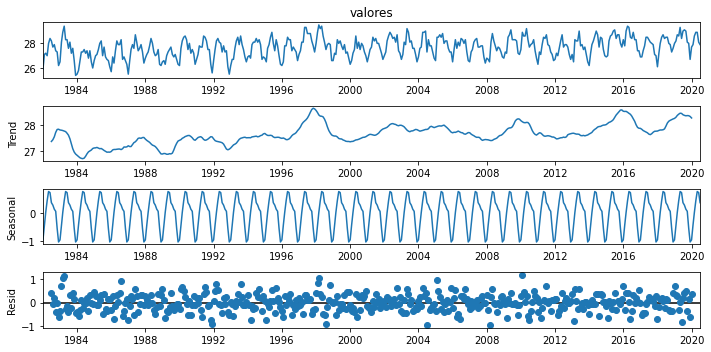

In [13]:
res = seasonal_decompose(df.valores, model="additive")
res.plot();

## Estacionalidad


Un patrón estacional se produce cuando una serie temporal se ve afectada por factores estacionales, como la época del año o el día de la semana. La estacionalidad tiene siempre una frecuencia fija y conocida.



In [14]:
df2 = df.copy()
df2.head()

,valores
month,
1982-01-01,25.9
1982-02-01,27.1
1982-03-01,27.2
1982-04-01,27.0
1982-05-01,28.0


In [15]:
df2["year"] = df2.index.year
df2["month"] = df2.index.month
df2.head()

,valores,year,month
month,,,
1982-01-01,25.9,1982,1
1982-02-01,27.1,1982,2
1982-03-01,27.2,1982,3
1982-04-01,27.0,1982,4
1982-05-01,28.0,1982,5


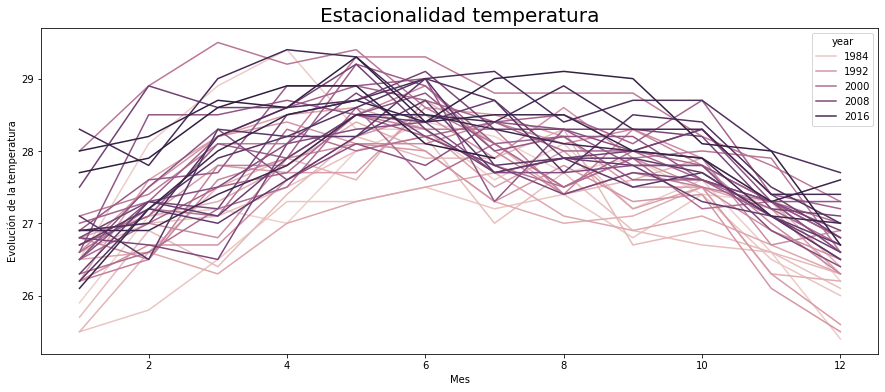

In [16]:
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(df2['month'], df2['valores'], hue=df2['year'])
ax.set_title('Estacionalidad temperatura', fontsize = 20, loc='center')
ax.set_xlabel('Mes')
ax.set_ylabel('Evolución de la temperatura');

## Estacionaridad

Existe una tendencia cuando hay un aumento o una disminución a largo plazo en los datos. No tiene por qué ser lineal. A veces se dice que una tendencia "cambia de dirección" cuando puede pasar de una tendencia creciente a una tendencia decreciente. Se puede decir que una serie es estacionaria cuando **su media y su varianza no están en función del tiempo**, es decir, son constantes en el tiempo.

La estacionariedad es importante porque la mayoría de los métodos estadísticos para realizar análisis y predicciones se basan en la suposición de que las propiedades estadísticas de la serie (media, varianza, correlación, etc.) son constantes en el tiempo.

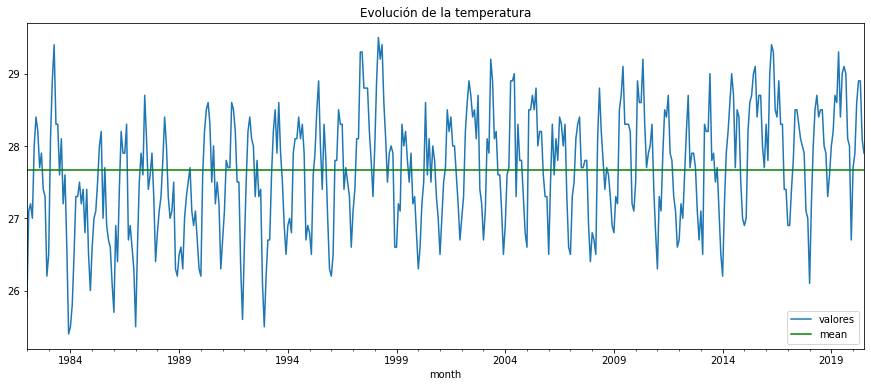

In [17]:
df.plot(figsize=(15,6))
plt.title("Evolución de la temperatura")
plt.axhline(df.valores.mean(), c="g", label="mean")
plt.legend();


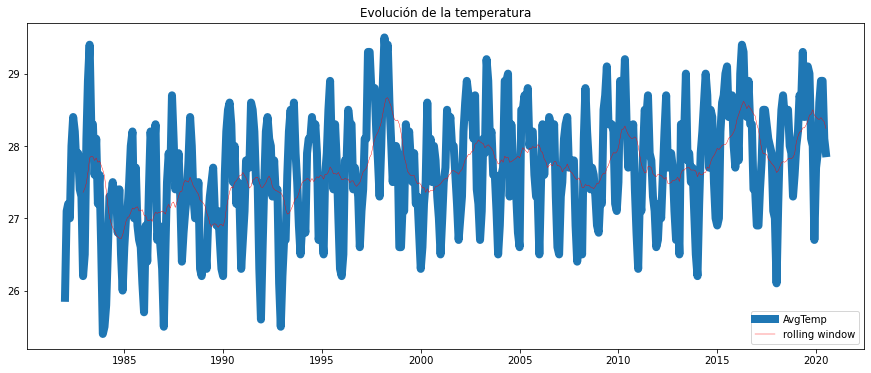

In [18]:
plt.figure(figsize=(15,6))
plt.title("Evolución de la temperatura")

plt.plot(df["valores"], label="AvgTemp", linewidth=8)
plt.plot(df.rolling(window = 12).mean(), label="rolling window", c= "r", linewidth = 0.4)

plt.legend();

Al plotear la media junto con los puntos de datos originales, podemos ver que son  algo constantes en el tiempo, no vemos ninguna tendencia de incremento o disminución. Sin embargo, parecen seguir un comportamiento. cíclico. Pero esto nos puede convencer poco, también podemos hacer el test de ADFuller

In [19]:
res_ad = adfuller(df["valores"])
res_ad

(-4.368361370596972,
 0.0003375321830769856,
 18,
 444,
 {'1%': -3.4451642100030084,
  '5%': -2.8680716196949327,
  '10%': -2.5702491139112085},
 572.4644501818075)

In [20]:
# pongamosle etiquetas a los resultados
print('ADF Statistic:', res_ad[0])
print('p-value:', res_ad[1])
print('Critical Values:')
for key, value in res_ad[4].items():
    print( "\t",  key, round(value, 2))

ADF Statistic: -4.368361370596972
p-value: 0.0003375321830769856
Critical Values:
	 1% -3.45
	 5% -2.87
	 10% -2.57


¿Cuáles son las conclusiones de esta prueba?

A partir de los resultados del test de Dickey Fuller podemos observar dos cosas:

- Si adf > valores_críticos  ==> DATOS NO ESTACIONARIOS

- pvalue> 0.05  ==> DATOS NO ESTACIONARIOS

En nuestro caso, nuestros datos son estacionarios! 

## Comparativa estacionalidad vs estacionaridad

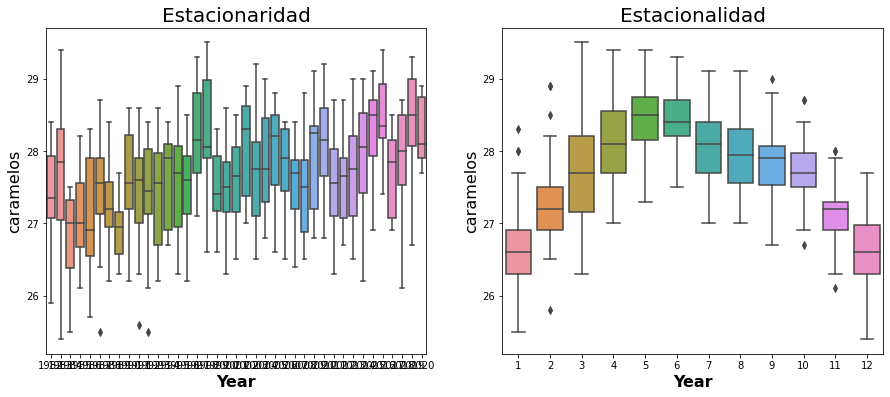

In [21]:
# nos creamos una lista con las columnas de tiempo
tiempo = df2.columns.drop("valores")

componentes = ["Estacionaridad", "Estacionalidad"]

#iniciamos los subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# hacemos nuestro for para no repetir lineas de código
for i, col in enumerate(tiempo):
    sns.boxplot(df2[col], df2["valores"], ax=ax[i])
    ax[i].set_title(componentes[i], fontsize = 20, loc='center')
    ax[i].set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
    ax[i].set_ylabel('caramelos', fontsize = 16)
plt.show()

# Autocorrelación

La autocorrelación es un tipo de dependencia temporal. En concreto, la autocorrelación se produce cuando una serie temporal está relacionada linealmente con una versión retardada de la misma. 

**Se trata de una medida de la correlación de los datos de la serie temporal en un momento dado con los valores pasados, lo que tiene enormes implicaciones en muchos sectores. Por ejemplo, si nuestros datos de ventas de caramelos tienen una fuerte autocorrelación, podemos suponer que un número elevado de ventas hoy sugiere una fuerte probabilidad de que también sea elevado mañana**


Quizás el aspecto más convincente del análisis de autocorrelación es cómo puede ayudarnos a descubrir patrones ocultos en nuestros datos y a seleccionar los métodos de previsión correctos. En concreto, podemos utilizarlo para ayudar a identificar la estacionalidad y la tendencia en nuestros datos de series temporales. Además, el análisis conjunto de la función de autocorrelación (ACF) y la función de autocorrelación parcial (PACF) es necesario para seleccionar el modelo ARIMA adecuado para la predicción de series temporales.

- `Auto-correlación`: la correlación entre dos momentos/instantes de tiempo.


- `Auto-correlación parcial`: es una medida de la correlación entre observaciones de una serie de tiempo que se encuentran separadas por k unidades de tiempo (yt y yt-k), después de ajustarse para la presencia de los demás términos de desfase más corto (yt-1, yt-2, ..., yt–k–1).

![auto](https://github.com/Ironhack-Part-Time-Enero2022/apuntes-clases/blob/master/semana-20/imagenes/autocorrelation-anatomy-python.jpg?raw=true)

In [22]:
corr_lag1 = df['valores'].autocorr(lag=1)
print("Un mes Lag: ", corr_lag1)

Un mes Lag:  0.723097653461294


In [23]:
corr_lag3 = df['valores'].autocorr(lag=3)
print("Dos meses Lag: ", corr_lag3)

corr_lag6 = df['valores'].autocorr(lag=6)
print("Seis meses Lag: ", corr_lag6)

corr_lag9 = df['valores'].autocorr(lag=9)
print("Nueve meses Lag: ", corr_lag9)

Dos meses Lag:  0.16726948619310658
Seis meses Lag:  -0.23506213283039426
Nueve meses Lag:  0.11148078934744755


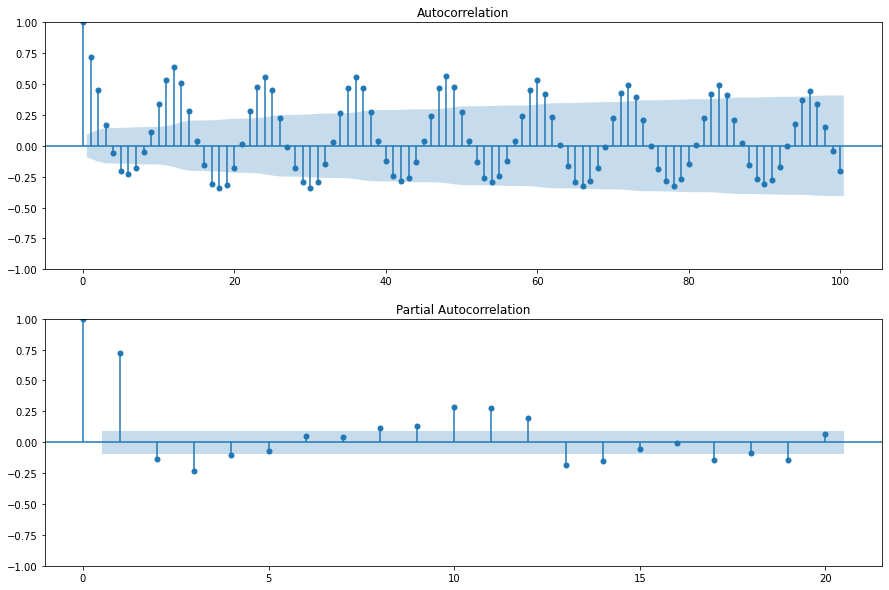

In [24]:
fig, axes = plt.subplots(2, 1, figsize=(15,10))
plot_acf(df, lags=100, ax= axes[0])
plot_pacf(df, lags=20, ax= axes[1]);

# Modelo ARMA

El modelo ARMA, del inglés, *AutoRegressive Moving Average* se divide en dos partes:

- `Autorregresivo(AR)`: la variable dependiente se regresa en sí misma en un período de tiempo t. **Será la `p` y lo sacaremos de la gráfica de autocorrelación**


- `Media móvil(MA)`: los retrocesos son representados por procesos aleatorios. **Será la `q` y lo sacaremos de la gráfica de autocorrelación parcial**



> la d es el número de diferencias no estacionales. En este caso SIEMPRE SERÁ 0. 


Lo primero que tenemos que hacer es separar nuestros datos en *train* y *test*, para seguir con buenas prácticas y ver si nuestras predicciones están *overfiteadas* 

In [25]:
y_test = df["valores"][-30:]
y_train = df["valores"][:-30]

In [26]:
ps = range(5)
qs = range(5)

parameters = list(product(ps, qs))
print(parameters)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]


In [27]:
%%time
rmse = []
order = []
for p,q in tqdm(parameters):
    try:
        modelo=ARIMA(y_train, order=(p, 0, q)).fit()
        pred = modelo.predict(start=len(y_train), end=len(df) -1)
        error = np.sqrt(np.mean(mean_squared_error(y_test, pred)))
        rmse.append(error)
        order.append((p,q))
    except: 
        continue

100%|█████████████████████████████████████████████| 25/25 [00:13<00:00,  1.86it/s]

CPU times: user 42.3 s, sys: 3.31 s, total: 45.6 s
Wall time: 13.5 s


In [28]:
results = pd.DataFrame({"RMSE": rmse, "order": order})
results.sort_values(by="RMSE", inplace=True)

In [29]:
results.head()

,RMSE,order
23,0.762138,"(4, 3)"
19,0.769086,"(3, 4)"
13,0.771267,"(2, 3)"
17,0.778538,"(3, 2)"
14,0.778630,"(2, 4)"


In [30]:
# fiteamos el modelo con los valores obtenidos de la tabla anterior y predecimos

modelo=ARIMA(y_train, order=(4, 0, 3)).fit()
pred = pd.DataFrame(modelo.predict(start=len(y_train), end=len(df) -1))

In [31]:
fecha = pd.date_range("2018-02-01", periods=30, freq="MS")

In [32]:
pred.index = fecha

In [33]:
pred.head()

,predicted_mean
2018-02-01,26.675713
2018-03-01,27.194047
2018-04-01,27.748631
2018-05-01,28.104491
2018-06-01,28.343332


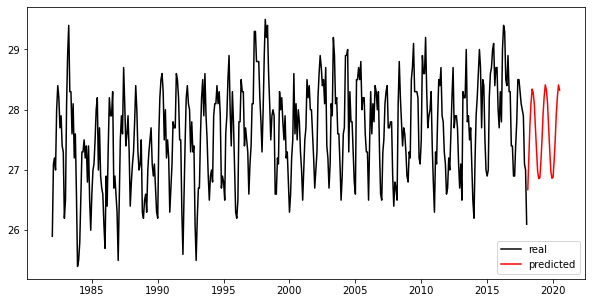

In [34]:
# veamos graficamente las predicciones
plt.plot(y_train, c = "black")
plt.plot(pred, c = "r")
plt.legend(["real", "predicted"]);

In [35]:
# añadimos al df de las predicciones los valores reales para compararlos con los predichos
pred["real"] = y_test

In [36]:
pred.head()

,predicted_mean,real
2018-02-01,26.675713,27.2
2018-03-01,27.194047,28.0
2018-04-01,27.748631,28.5
2018-05-01,28.104491,28.7
2018-06-01,28.343332,28.4


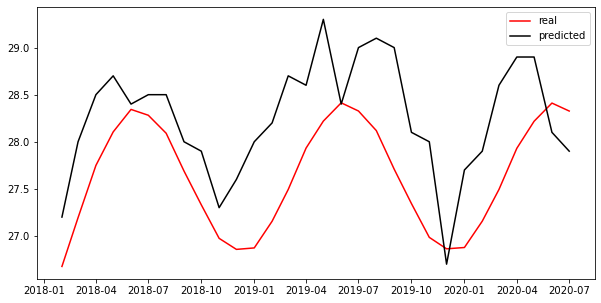

In [37]:
plt.plot(pred['predicted_mean'], c = "r")
plt.plot(pred["real"], c = "black")
plt.legend(["real", "predicted"]);

**Vamos a hacer predicciones más allá de los datos que tenemos, en concreto intentaremos predecir los siguientes doce meses**

In [38]:
fecha2 = pd.date_range("2020-07-01", periods=12, freq="MS")
fecha2

DatetimeIndex(['2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01'],
              dtype='datetime64[ns]', freq='MS')

In [39]:
pred2 = pd.DataFrame(modelo.predict(start=len(df) , end=len(df)  + 12))

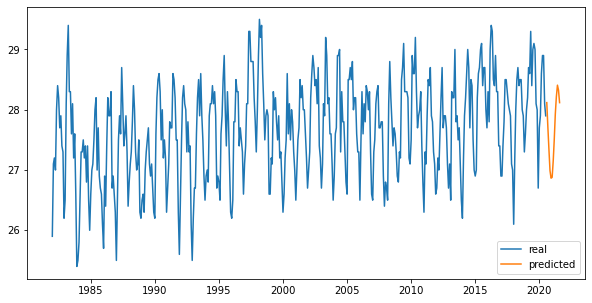

In [40]:
# ploteamos los resultados

plt.plot(df)
plt.plot(pred2)
plt.legend(["real", "predicted"]);

In [41]:
df2 = df[df.index.year > 2017]
df2.head()

,valores
month,
2018-01-01,26.1
2018-02-01,27.2
2018-03-01,28.0
2018-04-01,28.5
2018-05-01,28.7


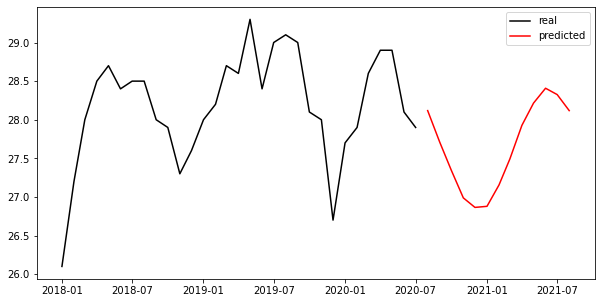

In [42]:
plt.plot(df2, c = "black")
plt.plot(pred2, c = "r")
plt.legend(["real", "predicted"]);